In [1]:
try:
    import google.colab

    !wget https://github.com/matt-graham/jax-sci-comp-demo/raw/refs/heads/main/requirements.txt
    !wget https://github.com/matt-graham/jax-sci-comp-demo/raw/refs/heads/main/hodgkin-huxley-potassium-data.npz
    !pip install -r requirements.txt
except ImportError:
    pass

In [2]:
import array_api_compat
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

jax.config.update("jax_enable_x64", True)
plt.rcParams.update({"font.size": 12})
%config InlineBackend.figure_format="retina"

# JAX for scientific computing demo

## The Hodgkin-Huxley model for action potential generation

As an example of a scientific computing task, we will consider [a mathematical model describing how action potentials in neurons are generated](https://en.wikipedia.org/wiki/Hodgkin%E2%80%93Huxley_model) and how we might fit that model to data. The model of interest was described by [Hodgkin and Huxley in 1952](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1392213/) based on experimental investigations with [squid giant axons](https://en.wikipedia.org/wiki/Squid_giant_axon), and they received the Nobel Prize in Physiology or Medicine for their work in 1963.

<img src="https://upload.wikimedia.org/wikipedia/commons/9/98/Hodgkin-Huxley.svg" style="margin: auto; margin-top: 2em;" width="30%" /> 

<small>Image source: [Wikimedia Commons](https://upload.wikimedia.org/wikipedia/commons/9/98/Hodgkin-Huxley.svg) </small>

The [cell membrane voltage $V_m$](https://en.wikipedia.org/wiki/Membrane_potential) is modelled as being controlled by [voltage-gated ion channels](https://en.wikipedia.org/wiki/Voltage-gated_ion_channel), with governing [ordinary differential equation (ODE)](https://en.wikipedia.org/wiki/Ordinary_differential_equation)

$$
 C_m \frac{\mathrm{d}V_m}{\mathrm{d}t} = g_K (E_K - V_m) + g_{Na}(E_{Na} - V_m) + g_L(E_l - V_m) - I.
$$

where 

- $C_m$ is the membrane capacitance per unit area, 
- $g_K$ is the potassium channel conductance, 
- $E_k$ the potassium channel reversal potential,
- $g_{Na}$ is the sodium channel conductance,
- $E_{Na}$ is the sodium channel reversal potential,
- $g_L$ is the leakage conductance,
- $E_L$ is the leakage reversal potential,
- and $I$ is the membrane current per unit area.


Importantly the potassium and sodium channel conductances, $g_K$ and $g_{Na}$, 
are themselves time and voltage dependent variables. 
In Hodgkin and Huxley's experiments they used an ingenious [experimental protocol](https://en.wikipedia.org/wiki/Voltage_clamp)
to allow measuring the evolution of the cell membrane's conductance over time for specific ion channels
while clamped to a specific depolarization voltage. 
By varying the extracellular ion concentrations, 
they were able to isolate the effects of the potassium and sodium channels. 
Here we will concentrate on the model and data specifically for $g_{K}$, the potassium channel conductance. 

## Potassium channel conductance model

The potassium channel conductance is modelled as

$$g_{\textrm{K}}(t, v, \theta) = \bar{g}_{\textrm{K}} n(t, v, \theta)^4$$

where $\bar{g}_K$ is the maximum potassium channel conductance, $n$ is a time and voltage dependent subunit activation probability in $[0, 1]$, $v = V_{\text{rest}} - V_m$ is the depolarization from the resting potential $V_{\text{rest}}$ in mV and $\theta = (\bar{g}_K, k_{\alpha,1}, k_{\alpha, 2}, k_{\alpha, 3}, k_{\beta, 1}, k_{\beta,2})$ are a set of model parameters.

In [3]:
def solve_for_potassium_conductance(t, v, parameters):
    n = solve_for_potassium_channel_subunit_activation(t, v, parameters)
    return parameters["g_bar_k"] * n**4

The potassium channel subunit activation $n$ is governed by a linear ODE

$$\frac{\mathrm{d} n(t, v, \theta)}{\mathrm{d} t} = \frac{n_\infty(v, \theta) - n(t, v, \theta)}{\tau(v, \theta)}$$

which has the analytic solution

$$
  n(t, v, \theta) = n(0, v, \theta) + \left(n_\infty(v, \theta) - n(0, v, \theta)\right) \left(1 - \exp(-t / \tau(v, \theta)) \right).
$$

In [4]:
def solve_for_potassium_channel_subunit_activation(t, v, parameters):
    xp = array_api_compat.array_namespace(t, v)
    n_0 = n_infty(xp.array(0), parameters)  # Assume start from equilibrium at V_rest
    return n_0 + (n_infty(v, parameters) - n_0) * (1 - xp.exp(-t / tau(v, parameters)))

The time constant $\tau$ and equilibrium value $n_\infty$ are defined respectively in terms of rate constant functions $\alpha$ and $\beta$ as

$$
  \tau(v, \theta) = \frac{1}{\alpha(v, \theta) + \beta(v, \theta)},\quad
  n_\infty(v, \theta) = \frac{\alpha(v, \theta)}{\alpha(v, \theta) + \beta(v, \theta)}.
$$

In [5]:
def n_infty(v, parameters):
    return alpha(v, parameters) / (alpha(v, parameters) + beta(v, parameters))


def tau(v, parameters):
    return 1 / (alpha(v, parameters) + beta(v, parameters))

The rate constants $\alpha$ and $\beta$ are themselves defined respectively in terms of the model parameters as

$$
  \alpha(v, \theta) =  \frac{k_{\alpha, 1}(v + k_{\alpha, 2})}{\exp((v + k_{\alpha, 2}) / k_{\alpha, 3}) - 1},
  \quad
  \beta(v, \theta) = k_{\beta, 1} \exp(v / k_{\beta, 2}).
$$

In [6]:
def alpha(v, parameters):
    xp = array_api_compat.array_namespace(v)
    return (
        parameters["k_alpha_1"]
        * (v + parameters["k_alpha_2"])
        / (xp.exp((v + parameters["k_alpha_2"]) / parameters["k_alpha_3"]) - 1)
    )


def beta(v, parameters):
    xp = array_api_compat.array_namespace(v)
    return parameters["k_beta_1"] * xp.exp(v / parameters["k_beta_2"])

Together these equations define a mathematical model for how the potassium conductance $g_K$
varies as a function of the applied depolarization and time, 
with six unknown model parameters $\theta = (k_{\alpha,1}, k_{\alpha,2}, k_{\alpha,3}, k_{\beta,1}, k_{\beta,2}, \bar{g}_K)$
that need to be inferred from the experimental data.
In Hodgkin and Huxley's experiments,
the potassium conductances were measured at regular time intervals for a series of applied depolarizations.

## Evaluating model functions with NumPy and JAX arrays

We will start off by using fixed parameter values, taking those fitted by Hodgkin and Huxley to experimental data in their 1952 paper.

In [7]:
parameters = {
    "g_bar_k": 35.0,
    "k_alpha_1": 0.01,
    "k_alpha_2": 10.0,
    "k_alpha_3": 10.0,
    "k_beta_1": 0.125,
    "k_beta_2": 80.0,
}

First we create a NumPy array of linearly spaced depolarizations to evaluate the model functions at.

In [8]:
depolarizations_numpy = np.linspace(-200, 200, 200)
type(depolarizations_numpy)

numpy.ndarray

To create a corresponding JAX array we can straightforwardly use the JAX NumPy API we imported earlier as `jnp`.

In [9]:
depolarizations_jax = jnp.linspace(-200, 200, 200)
type(depolarizations_jax)

jaxlib._jax.ArrayImpl

As expected, calling model functions on the NumPy array produces a NumPy array as output:

In [10]:
beta_numpy = beta(depolarizations_numpy, parameters)
type(beta_numpy)

numpy.ndarray

and calling on a JAX array produces a JAX array as output:

In [11]:
beta_jax = beta(depolarizations_jax, parameters)
type(beta_jax)

jaxlib._jax.ArrayImpl

with the two output arrays being equal modulo floating point error differences:

In [12]:
assert np.allclose(beta_numpy, beta_jax)

We can also visualize the equivalence of the function outputs

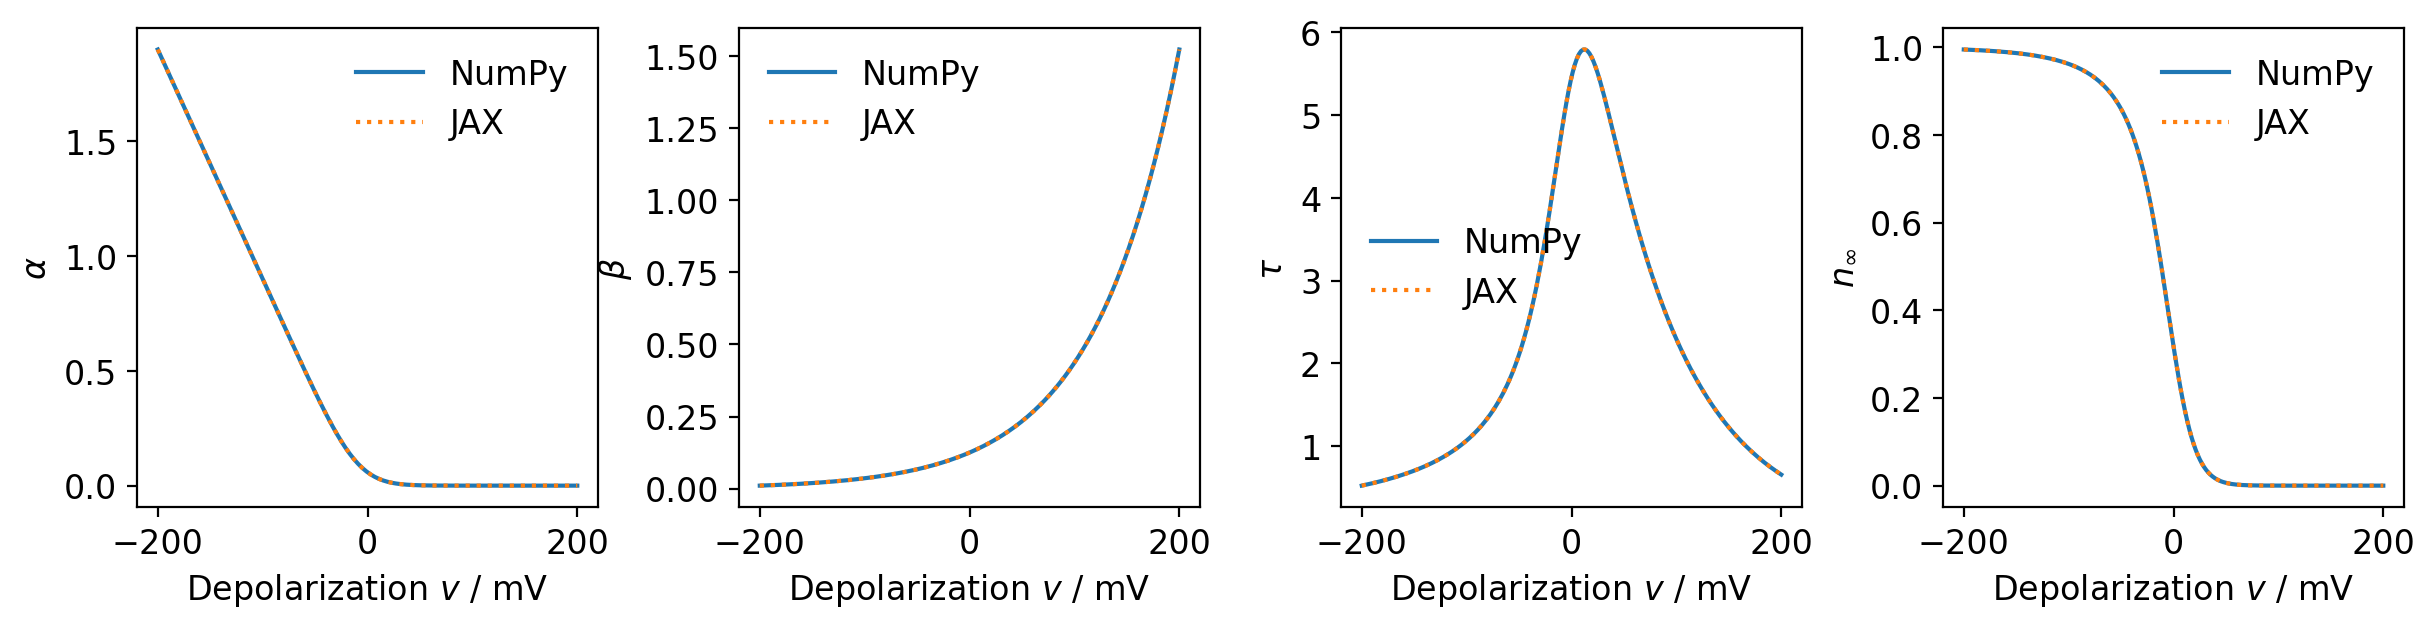

In [13]:
labelled_functions = {
    r"$\alpha$": alpha,
    r"$\beta$": beta,
    r"$\tau$": tau,
    r"$n_\infty$": n_infty,
}
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for (label, function), ax in zip(labelled_functions.items(), axes):
    ax.plot(
        depolarizations_numpy,
        function(depolarizations_numpy, parameters),
        label="NumPy",
    )
    ax.plot(
        depolarizations_jax, function(depolarizations_jax, parameters), ":", label="JAX"
    )
    ax.set(xlabel="Depolarization $v$ / mV", ylabel=label)
    ax.legend(frameon=False)
fig.tight_layout(pad=0)

## Performance of functions on NumPy versus JAX arrays

How do the functions using NumPy and JAX arrays compare in terms of compute time? First to ensure a fair comparison we define a helper function which calls a function and then (optionally) blocks until any asynchronously executed operations are completed due to [JAX's asynchronous dispatch model](https://jax.readthedocs.io/en/latest/async_dispatch.html#async-dispatch)

In [14]:
def call_and_block(function, block, *args):
    return function(*args).block_until_ready() if block else function(*args)

Now we time calling each of the functions with the [`timeit` magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit) for both NumPy and JAX arrays and record the results

In [15]:
timings = {}
depolarization_arrays = {"numpy": depolarizations_numpy, "jax": depolarizations_jax}
for lib, depolarizations in depolarization_arrays.items():
    print("-" * 80 + "\n" + lib + "\n" + "-" * 80)
    timings[lib] = {}
    for function in labelled_functions.values():
        print(function.__name__)
        timings[lib][
            function.__name__
        ] = %timeit -o call_and_block(function, lib == "jax", depolarizations, parameters)

--------------------------------------------------------------------------------
numpy
--------------------------------------------------------------------------------
alpha
16.8 μs ± 1.28 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
beta
9.14 μs ± 1.05 μs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
tau
26.2 μs ± 2.28 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
n_infty
41.4 μs ± 4 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
--------------------------------------------------------------------------------
jax
--------------------------------------------------------------------------------
alpha
124 μs ± 6.03 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
beta
53.3 μs ± 3.34 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
tau
234 μs ± 17.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
n_infty
323 μs ± 19.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


We can see that when evaluating on JAX arrays the functions are consistently and significantly slower! This can be seen even more clearly by plotting the timing results

In [16]:
def plot_timing_comparison(timings):
    fig, ax = plt.subplots()
    bar_width = 1 / (len(timings) + 1)
    for i, (lib, per_function_times) in enumerate(timings.items()):
        bar_locs = np.arange(len(per_function_times)) + bar_width * i
        mean_times = [v.average for v in per_function_times.values()]
        std_times = [v.stdev for v in per_function_times.values()]
        function_names = list(per_function_times.keys())
        ax.bar(bar_locs, mean_times, bar_width, label=lib)
        ax.errorbar(bar_locs, mean_times, yerr=std_times, fmt="none", color="k")
    ax.set(xlabel="Function", ylabel="Time / s")
    ax.set_xticks(bar_locs - (len(timings) - 1) * bar_width / 2, function_names)
    ax.legend()
    return fig, ax

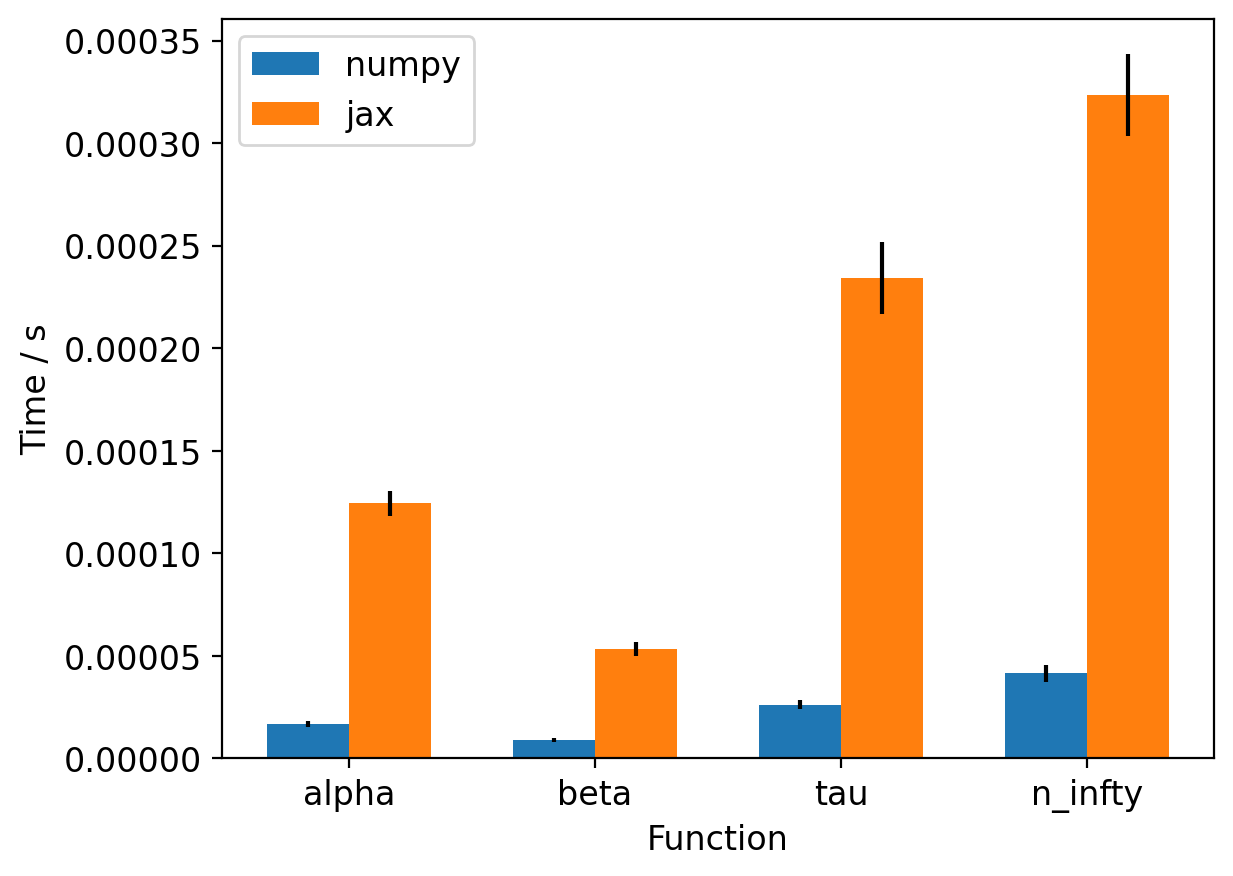

In [17]:
_ = plot_timing_comparison(timings)

This may at first seem surprising as JAX describes itself as a performance-oriented library. However, 

- NumPy operations are executed eagerly and synchronously.
- JAX operations may be executed eagerly or after compilation and they are dispatched asynchronously.

This has led to different priorities in the packages: for example, NumPy has put significant effort into decreasing the per-call dispatch overhead for individual array operations, because in NumPy’s computational model that overhead cannot be avoided. JAX, on the other hand, has several ways to avoid dispatch overhead and so reducing per-call overhead has been less of a priority. 

(Text adapted from: https://jax.readthedocs.io/en/latest/faq.html#is-jax-faster-than-numpy)

One particular way of reducing dispatch overhead offered by JAX is just-in-time (JIT) compilation. Before we try out JIT compilation we will first take a look at how JAX's function transformations work.

## JAX tracing and jaxprs

At a high level, JAX's function transformations, operate by first tracing the Python function to be transformed to an [intermediate representation (IR)](https://en.wikipedia.org/wiki/Intermediate_representation), with this IR then interpreted with a transformation specific [interpreter](https://en.wikipedia.org/wiki/Interpreter_(computing)). Jaxprs are JAX’s internal IR of traced programs. They are explicitly typed, [functional](https://en.wikipedia.org/wiki/Functional_programming), first-order, and in [algebraic normal form](https://en.wikipedia.org/wiki/Algebraic_normal_form).

(Adapted from: https://jax.readthedocs.io/en/latest/jaxpr.html)

Consider the `beta` function defined earlier:

In [18]:
%psource beta

def beta(v, parameters):
    xp = array_api_compat.array_namespace(v)
    return parameters["k_beta_1"] * xp.exp(v / parameters["k_beta_2"])


JAX provides a special `jax.make_jaxpr` transformation that allows us to inspect the jaxpr representation of a trace function. Applying to `beta` and then calling the resulting function with the example arguments used earlier:

In [19]:
jax.make_jaxpr(beta)(depolarizations_jax, parameters)

{ lambda ; a:f64[200] b:f64[] c:f64[] d:f64[] e:f64[] f:f64[] g:f64[]. let
    h:f64[] = convert_element_type[new_dtype=float64 weak_type=False] g
    i:f64[200] = div a h
    j:f64[200] = exp i
    k:f64[] = convert_element_type[new_dtype=float64 weak_type=False] f
    l:f64[200] = mul k j
  in (l,) }

Internally JAX traces functions with _abstract_ values. For most transformations the abstraction is at the level of the shape and datatype of arguments, but not their values. We can use the `jax.ShapedDtypeStruct` to create an abstract array with just `shape` and `dtype` attributes (plus some additional attributes for JAX bookkeeping such as device layout and sharding).

In [20]:
abstract_depolarizations = jax.ShapeDtypeStruct(
    depolarizations_jax.shape, depolarizations_jax.dtype
)
abstract_depolarizations

ShapeDtypeStruct(shape=(200,), dtype=float64)

If we now call the `jax.make_jaxpr` transformed function with this abstract argument we get exactly the same result as before

In [21]:
jax.make_jaxpr(beta)(abstract_depolarizations, parameters)

{ lambda ; a:f64[200] b:f64[] c:f64[] d:f64[] e:f64[] f:f64[] g:f64[]. let
    h:f64[] = convert_element_type[new_dtype=float64 weak_type=False] g
    i:f64[200] = div a h
    j:f64[200] = exp i
    k:f64[] = convert_element_type[new_dtype=float64 weak_type=False] f
    l:f64[200] = mul k j
  in (l,) }

Importantly any control flow in the in traced function is transparent to the tracing. Consider the `n_infty` function which calls functions `alpha` and `beta`

In [22]:
%psource n_infty

def n_infty(v, parameters):
    return alpha(v, parameters) / (alpha(v, parameters) + beta(v, parameters))


The jaxpr for this function corresponds to tracing through the full computation including nested calls.

In [23]:
jax.make_jaxpr(n_infty)(depolarizations_jax, parameters)

{ lambda ; a:f64[200] b:f64[] c:f64[] d:f64[] e:f64[] f:f64[] g:f64[]. let
    h:f64[] = convert_element_type[new_dtype=float64 weak_type=False] d
    i:f64[200] = add a h
    j:f64[] = convert_element_type[new_dtype=float64 weak_type=False] c
    k:f64[200] = mul j i
    l:f64[] = convert_element_type[new_dtype=float64 weak_type=False] d
    m:f64[200] = add a l
    n:f64[] = convert_element_type[new_dtype=float64 weak_type=False] e
    o:f64[200] = div m n
    p:f64[200] = exp o
    q:f64[200] = sub p 1.0:f64[]
    r:f64[200] = div k q
    s:f64[] = convert_element_type[new_dtype=float64 weak_type=False] d
    t:f64[200] = add a s
    u:f64[] = convert_element_type[new_dtype=float64 weak_type=False] c
    v:f64[200] = mul u t
    w:f64[] = convert_element_type[new_dtype=float64 weak_type=False] d
    x:f64[200] = add a w
    y:f64[] = convert_element_type[new_dtype=float64 weak_type=False] e
    z:f64[200] = div x y
    ba:f64[200] = exp z
    bb:f64[200] = sub ba 1.0:f64[]
    bc:f6

## Just-in-time compilation with `jax.jit`

One of the key JAX transformations is the `jax.jit` function which allows functions to be JIT compiled with XLA for execution on a particular device (CPU, GPU or TPU).

In [24]:
jitted_beta = jax.jit(beta)
jax.make_jaxpr(jitted_beta)(abstract_depolarizations, parameters)

{ lambda ; a:f64[200] b:f64[] c:f64[] d:f64[] e:f64[] f:f64[] g:f64[]. let
    h:f64[200] = jit[
      name=beta
      jaxpr={ lambda ; a:f64[200] b:f64[] c:f64[] d:f64[] e:f64[] f:f64[] g:f64[]. let
          i:f64[] = convert_element_type[new_dtype=float64 weak_type=False] g
          j:f64[200] = div a i
          k:f64[200] = exp j
          l:f64[] = convert_element_type[new_dtype=float64 weak_type=False] f
          h:f64[200] = mul l k
        in (h,) }
    ] a b c d e f g
  in (h,) }

The jitted and original functions give equivalent outputs to within floating point error

In [25]:
assert np.allclose(
    jitted_beta(depolarizations_jax, parameters), beta(depolarizations_jax, parameters)
)

The jitted function however is significantly faster 

In [26]:
print("Without jit")
%timeit beta(depolarizations_jax, parameters).block_until_ready()
print("With jit")
%timeit jitted_beta(depolarizations_jax, parameters).block_until_ready()

Without jit
54 μs ± 5.24 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
With jit
19.5 μs ± 1.09 μs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## `jax.jit`: under the hood

When calling a jitted function JAX does the following in order:

1. **Stage out** a specialized version of the original Python callable to an
   internal representation (jaxpr).
2. **Lower** this specialized, staged-out computation to the XLA compiler's
   input language, StableHLO.
3. **Compile** the lowered HLO program to produce an optimized executable for
   the target device (CPU, GPU, or TPU).
4. **Execute** the compiled executable with the arrays as arguments.

(Text adapted from: https://jax.readthedocs.io/en/latest/aot.html)

JAX has an ahead-of-time (AOT) compilation interface which allows us to separate out the steps (1, 2), 3, and 4.

Lowering a function on (potentially abstract) arguments allows us to view the StableHLO representation.

In [27]:
lowered_beta = jax.jit(beta).lower(abstract_depolarizations, parameters)
print(lowered_beta.as_text())

module @jit_beta attributes {mhlo.num_partitions = 1 : i32, mhlo.num_replicas = 1 : i32} {
  func.func public @main(%arg0: tensor<200xf64>, %arg1: tensor<f64>, %arg2: tensor<f64>) -> (tensor<200xf64> {jax.result_info = "result"}) {
    %0 = stablehlo.convert %arg2 : tensor<f64>
    %1 = stablehlo.broadcast_in_dim %0, dims = [] : (tensor<f64>) -> tensor<200xf64>
    %2 = stablehlo.divide %arg0, %1 : tensor<200xf64>
    %3 = stablehlo.exponential %2 : tensor<200xf64>
    %4 = stablehlo.convert %arg1 : tensor<f64>
    %5 = stablehlo.broadcast_in_dim %4, dims = [] : (tensor<f64>) -> tensor<200xf64>
    %6 = stablehlo.multiply %5, %3 : tensor<200xf64>
    return %6 : tensor<200xf64>
  }
}



We can then compile a lowered function - this for example allows us to avoid the overhead of compiling on the first execution in timing benchmarks, and also allows us to analyse the cost of the compiled function. Importantly however this compiled function is specific to the argument shapes and datatypes and cannot be further transformed.

In [28]:
compiled_beta = lowered_beta.compile()
display(compiled_beta.cost_analysis())

{'bytes accessed2{}': 8.0,
 'flops': 400.0,
 'bytes accessed': 3216.0,
 'transcendentals': 200.0,
 'utilization2{}': 1.0,
 'utilization1{}': 1.0,
 'bytes accessed1{}': 8.0,
 'bytes accessed0{}': 1600.0,
 'utilization0{}': 1.0,
 'bytes accessedout{}': 1600.0}

## Repeating performance comparison with `jax.jit`

We now time jitted versions of each of the functions and plot the comparisons as previously.

alpha
42.9 μs ± 6.05 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
beta
23 μs ± 1.19 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
tau
75.4 μs ± 4.7 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
n_infty
71.3 μs ± 3.54 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


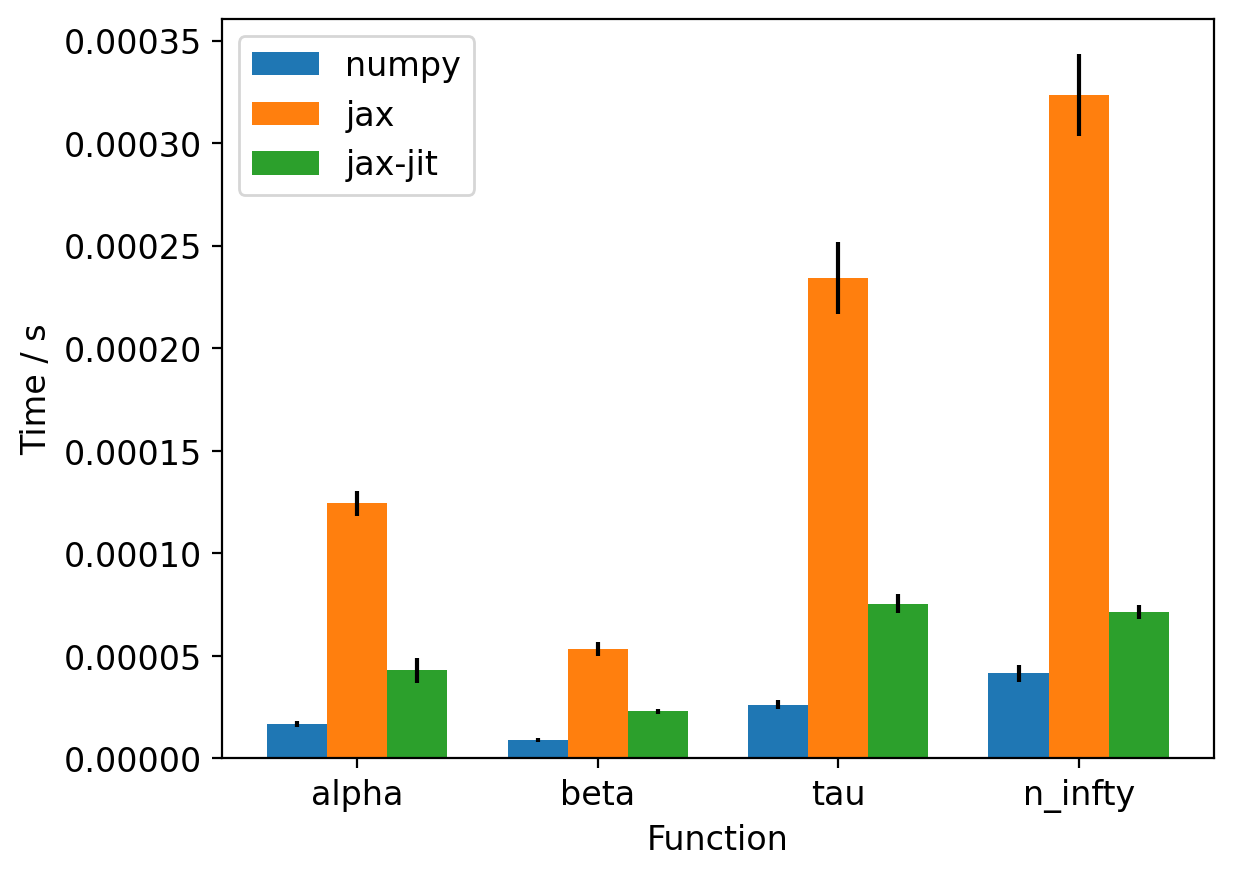

In [29]:
timings["jax-jit"] = {}
for function in labelled_functions.values():
    print(function.__name__)
    jitted_function = jax.jit(function).lower(depolarizations, parameters).compile()
    timings["jax-jit"][
        function.__name__
    ] = %timeit -o jitted_function(depolarizations, parameters).block_until_ready()
_ = plot_timing_comparison(timings)

We see that jitting gives a consistent significant performance improvement, and that improvement is generally larger for the functions with more traced operations (`tau` and `n_infty`). However performance is still worse than NumPy in these cases.

## Going larger: generating conductance time series

In general JAX will give greater speed-ups when operating on larger arrays and JIT compiling a larger function trace, due to the decreased effects of dispatch overhead. In our case the model functions we have been looking at so far are only components of the overall model we are interested in.

A key task in most modelling problems is fitting the model parameters to data. Below we load a digitization of the original potassium conductance time series experimental data for different polarizations analysed by Hodgkin and Huxley (1952).

In [30]:
data = dict(np.load("hodgkin-huxley-potassium-data.npz"))

We also define a helper function to let us visualize this data as a group of time series.

In [31]:
def plot_conductances(
    ax,
    times,
    depolarizations,
    conductances,
    show_legend=True,
    marker=".",
    linestyle=":",
):
    depolarization_colors = {
        v: color for v, color in zip(sorted(set(depolarizations)), plt.cm.tab20.colors)
    }
    for v, color in depolarization_colors.items():
        ax.plot(
            times[depolarizations == v],
            conductances[depolarizations == v],
            label=f"{v:.0f}",
            marker=marker,
            linestyle=linestyle,
            color=color,
        )
    ax.set(xlabel="Time / ms", ylabel="Conductance / mS cm$^{-2}$")
    if show_legend:
        _ = ax.legend(
            title="Depolarization / mV",
            loc="center left",
            frameon=False,
            bbox_to_anchor=(1.0, 0.5),
            ncol=1,
        )

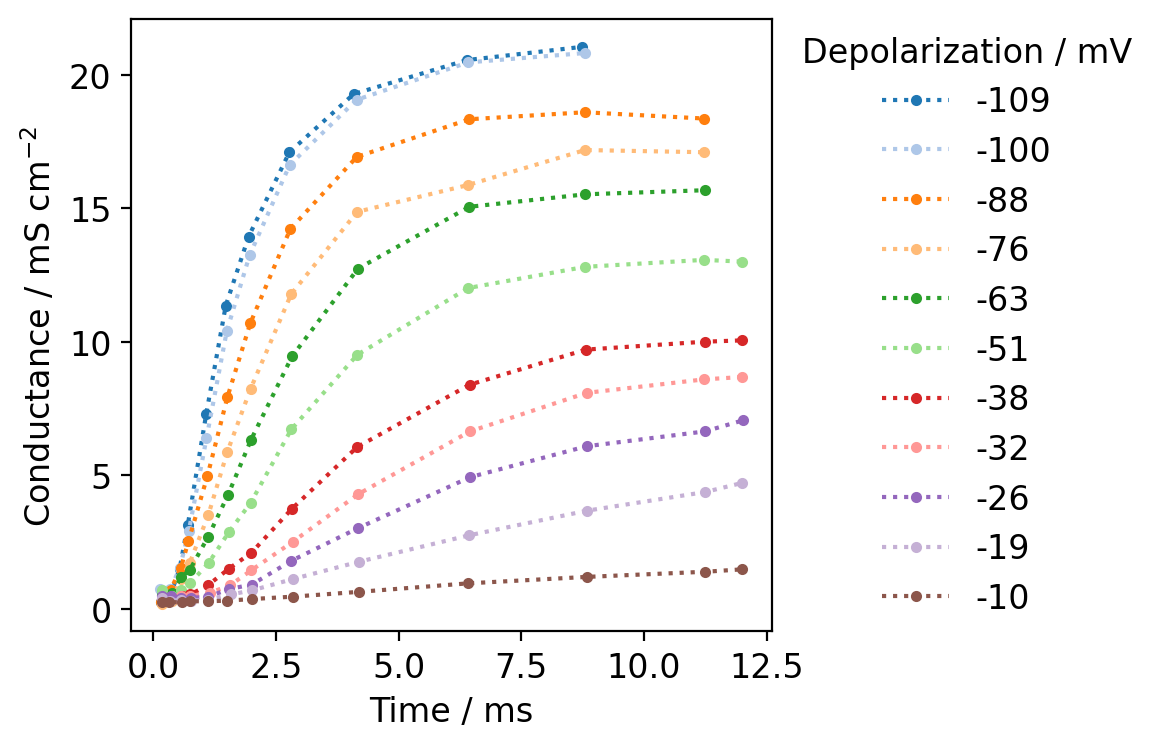

In [32]:
fig, ax = plt.subplots(figsize=(6, 4))
plot_conductances(ax, **data, show_legend=True)
fig.tight_layout()

The `solve_for_potassium_conductance` we defined earlier allows us to generate simulated conductance data using the model parameters from the paper, which we can plot using the same function

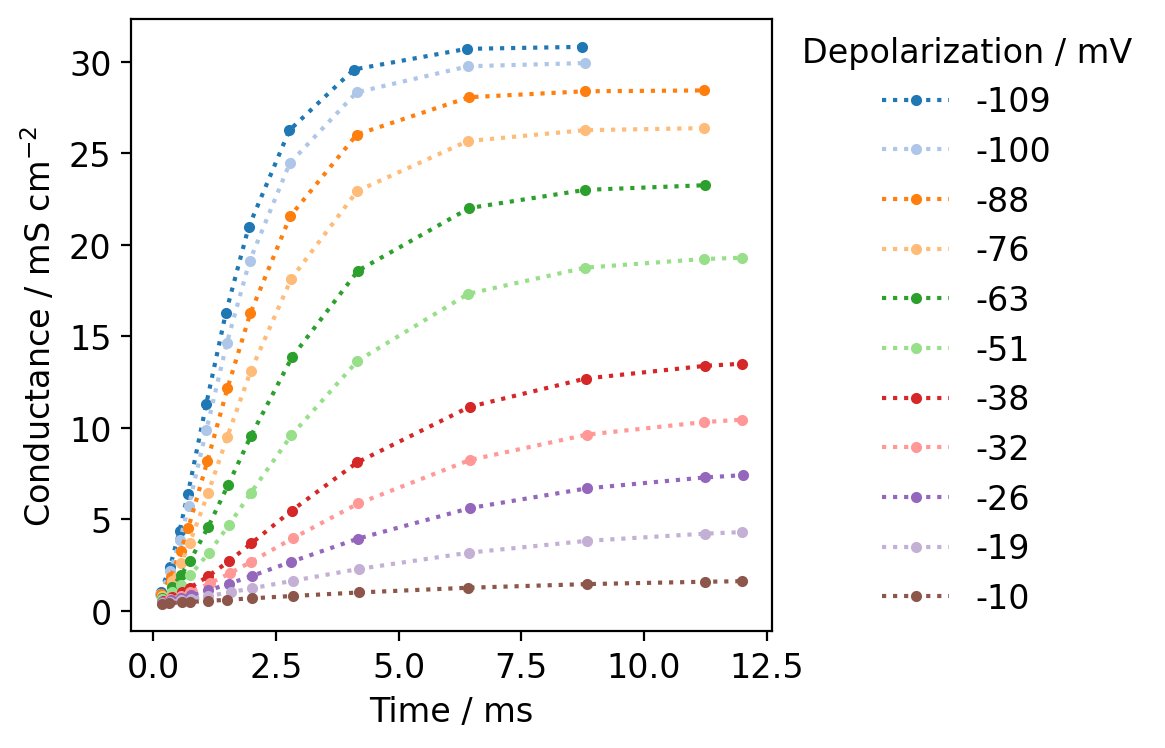

In [33]:
simulated_conductances = solve_for_potassium_conductance(
    data["times"], data["depolarizations"], parameters
)
fig, ax = plt.subplots(figsize=(6, 4))
plot_conductances(
    ax, data["times"], data["depolarizations"], simulated_conductances, show_legend=True
)
fig.tight_layout()

We see that the simulated and observed conductances are similar as we would hope! The `solve_for_potassium_conductance` function evaluates the model for vectors of both times and depolarizations, and has a much larger traced computation

In [34]:
jax.make_jaxpr(solve_for_potassium_conductance)(
    data["times"], data["depolarizations"], parameters
)

{ lambda ; a:f64[136] b:f64[136] c:f64[] d:f64[] e:f64[] f:f64[] g:f64[] h:f64[]. let
    i:f64[] = add 0.0:f64[] e
    j:f64[] = mul d i
    k:f64[] = add 0.0:f64[] e
    l:f64[] = div k f
    m:f64[] = exp l
    n:f64[] = sub m 1.0:f64[]
    o:f64[] = div j n
    p:f64[] = add 0.0:f64[] e
    q:f64[] = mul d p
    r:f64[] = add 0.0:f64[] e
    s:f64[] = div r f
    t:f64[] = exp s
    u:f64[] = sub t 1.0:f64[]
    v:f64[] = div q u
    w:f64[] = div 0.0:f64[] h
    x:f64[] = exp w
    y:f64[] = mul g x
    z:f64[] = add v y
    ba:f64[] = div o z
    bb:f64[] = convert_element_type[new_dtype=float64 weak_type=False] e
    bc:f64[136] = add b bb
    bd:f64[] = convert_element_type[new_dtype=float64 weak_type=False] d
    be:f64[136] = mul bd bc
    bf:f64[] = convert_element_type[new_dtype=float64 weak_type=False] e
    bg:f64[136] = add b bf
    bh:f64[] = convert_element_type[new_dtype=float64 weak_type=False] f
    bi:f64[136] = div bg bh
    bj:f64[136] = exp bi
    bk:f64[136] = 

We can JIT compile this function

In [35]:
jitted_solve_for_potassium_conductance = jax.jit(solve_for_potassium_conductance)
assert np.allclose(
    jitted_solve_for_potassium_conductance(
        data["times"], data["depolarizations"], parameters
    ),
    solve_for_potassium_conductance(data["times"], data["depolarizations"], parameters),
)

Comparing the performance executing using NumPy and (JIT compiled) JAX we now see JAX is now at least matching NumPy's performance:

In [36]:
print("NumPy")
%timeit solve_for_potassium_conductance(data["times"], data["depolarizations"], parameters)
print("Compiled JAX")
%timeit jitted_solve_for_potassium_conductance(data["times"], data["depolarizations"], parameters).block_until_ready()

NumPy
108 μs ± 4.05 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Compiled JAX
105 μs ± 4.4 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Fitting model parameters with approximate Bayesian computation

While we have been using the model parameters provided in the paper, typically we would first need to fit the model parameters. In Hodgkin and Huxley's case the parameters were fitted by matching hand-drawn curves to the data ([Daly et al. 2015](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4807457/))! In reality as data is generally noisy and models may be non identifiable, there will be a _distribution_ of parameters consistent with the observed data and our prior assumptions about the model.

One of the conceptually simplest approaches for finding this [(posterior) distribution](https://en.wikipedia.org/wiki/Posterior_probability) on the parameters, is to 

  1. simulate a large number of parameters that give model outputs consistent with our prior knowledge,
  2. compute simulated observed outputs for each parameter, compare to the observed data and keep on the parameter values for which simulations and observations are close.

This approach is sometimes called [_approximate Bayesian computation_](https://en.wikipedia.org/wiki/Approximate_Bayesian_computation).

For our purposes we will use a simple prior model in which the parameters are constrained to be positive and with appropriate scales, and to be a-priori independent. Given a unconstrained real-valued vector with elements sampled independently from a standard normal distribution, a prior sample of the positive valued parameters can then be generated by offseting and exponentiating these standard normal variates, corresponding to assuming a log-normal prior distribution on the parameters. 

Importantly defining the function to generate parameters in terms of a flat vector in an unconstrained space will later simplify optimizing the parameters without having to consider constraints.

In [37]:
prior_log_normal_locations = {
    "k_alpha_1": -3,
    "k_alpha_2": 2,
    "k_alpha_3": 2,
    "k_beta_1": -3,
    "k_beta_2": 2,
    "g_bar_k": 2,
    "sigma": 0,
}

dim_parameters = len(prior_log_normal_locations)


def generate_parameters(u):
    xp = array_api_compat.array_namespace(u)
    values = xp.exp(u + xp.array(list(prior_log_normal_locations.values())))
    return dict(zip(prior_log_normal_locations.keys(), values))

Given the function for generating parameters, we can now write a function to generate simulated conductance time series data given a vector of (unconstrained and normalized) parameter values.

In [38]:
def generate_conductances(u, data):
    parameters = generate_parameters(u)
    return solve_for_potassium_conductance(
        data["times"], data["depolarizations"], parameters
    )

We can then randomly generate parameters and plot the corresponding simulated outputs

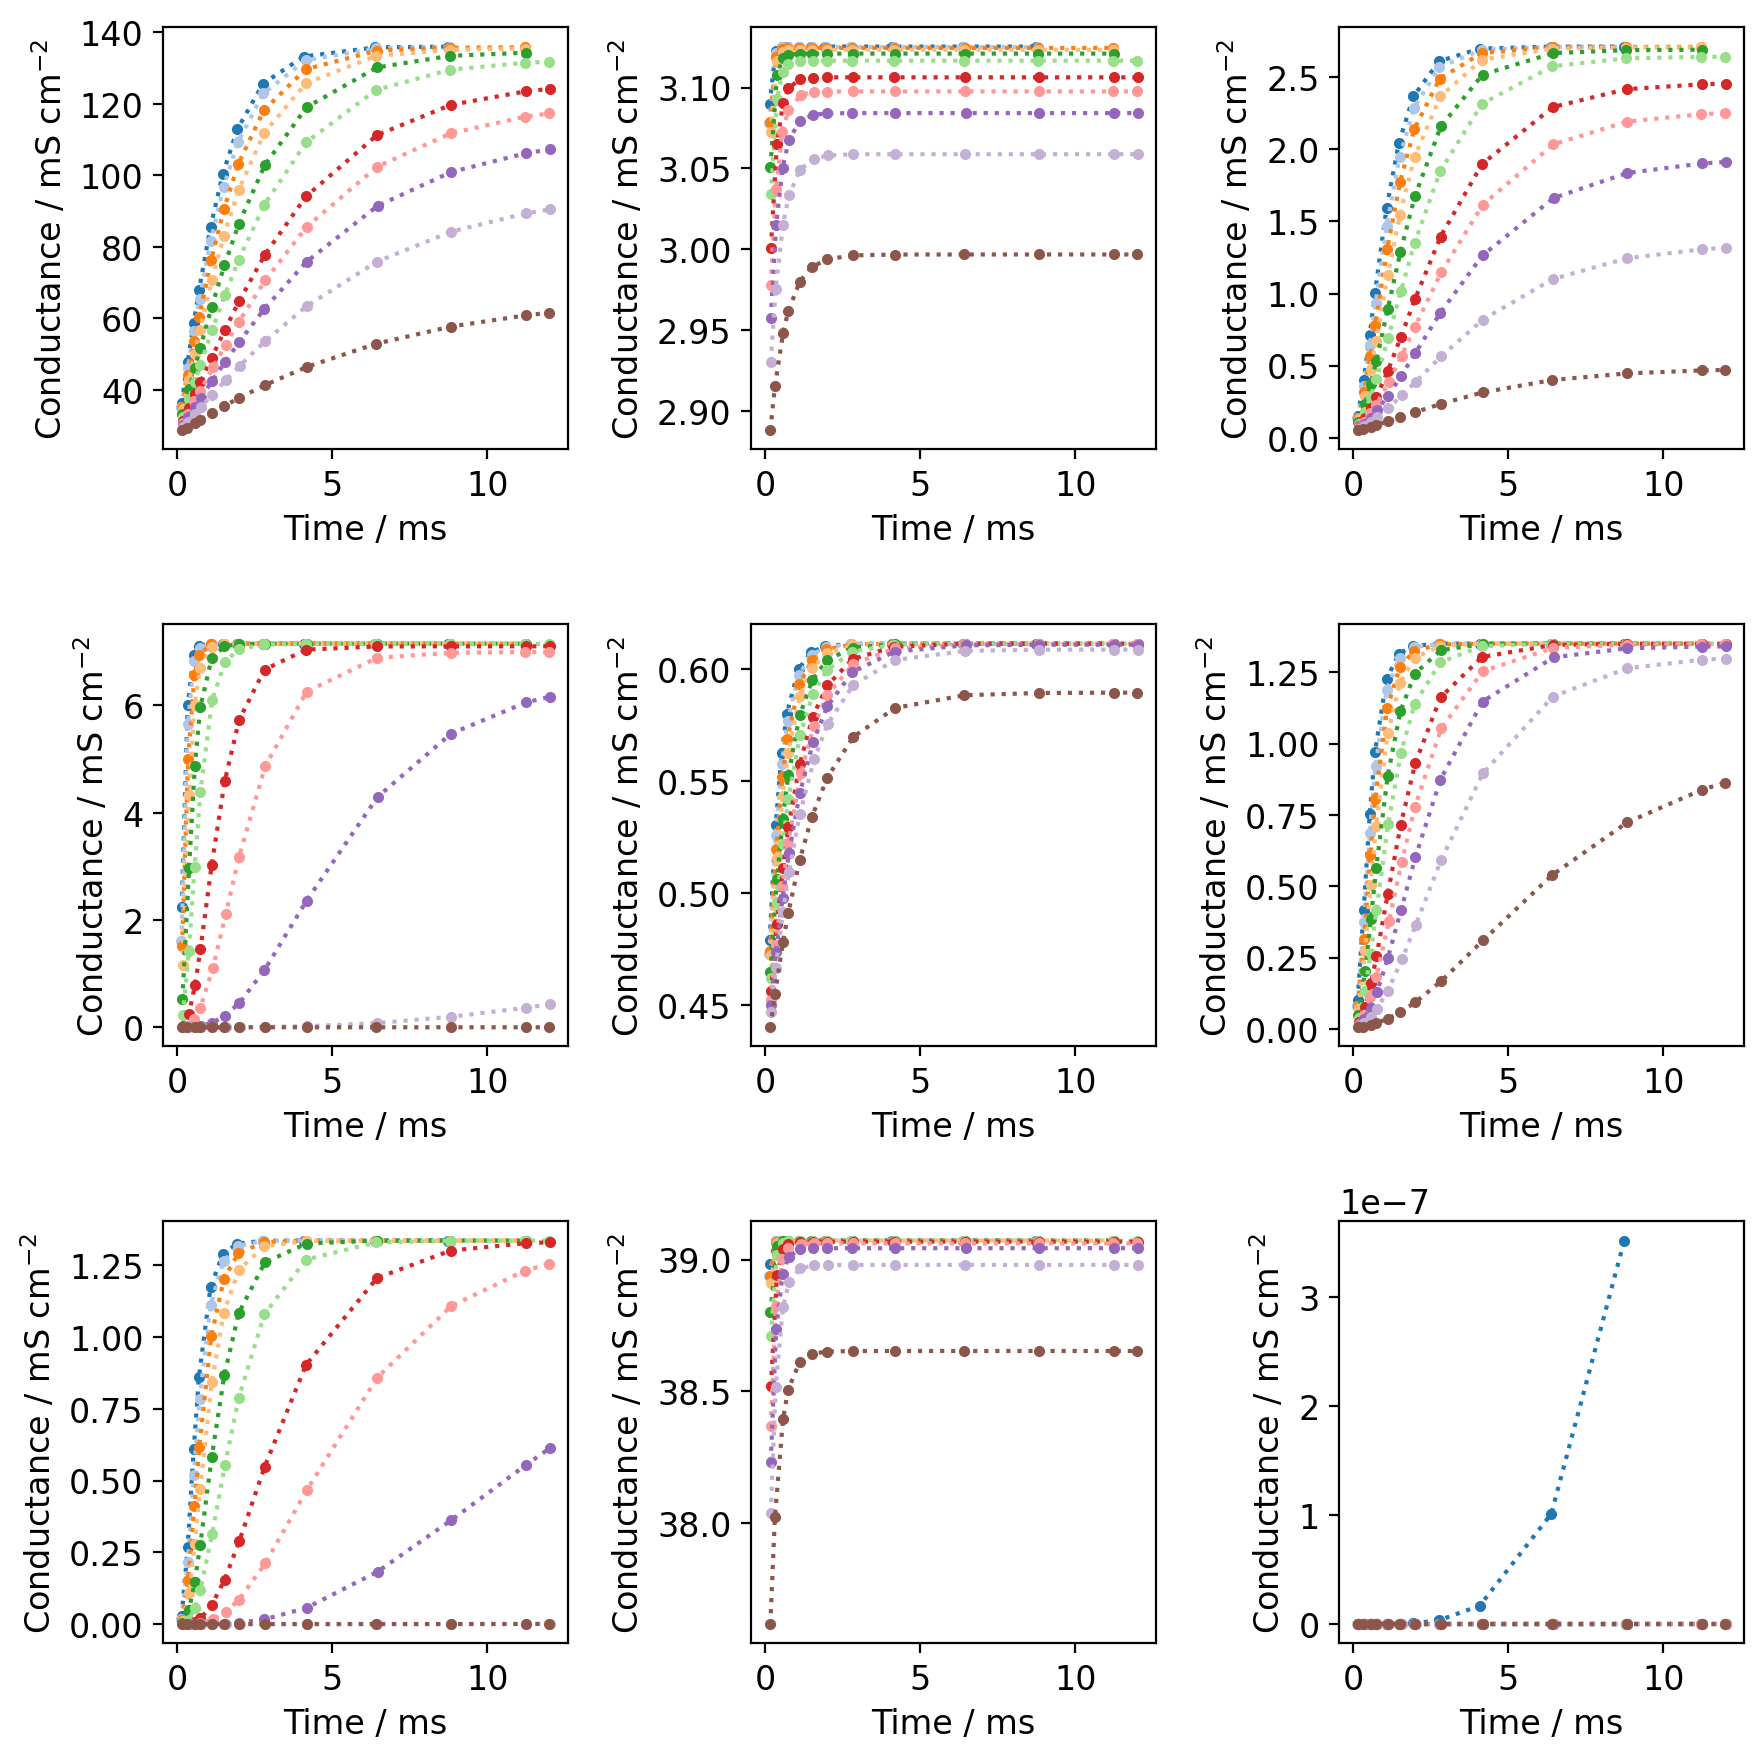

In [39]:
rng = np.random.default_rng(1234)
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
for ax in axes.flat:
    conductances = generate_conductances(rng.standard_normal(dim_parameters), data)
    plot_conductances(
        ax, data["times"], data["depolarizations"], conductances, show_legend=False
    )
fig.tight_layout()

## Vectorized simulation with `jax.vmap`

Simulating data for each parameter sequentially is relatively inefficient. Helpfully JAX provides a batching / vectorization transformation `jax.vmap` which allows us to evaluate a function for a batch of inputs simultaneously. While we can sometimes achieve this using NumPy broadcasting semantics, `vmap` avoids having to manually adjust code and correctly remember broadcasting rules. The `jax.vmap` transformation takes optional arguments specifying the argument axes over which to vectorize - here we indicate to vectorize only over the first axes of the first argument `u` to `generate_conductances`. Notice also that we can compose `jax.vmap` with `jax.jit`.

In [40]:
vmapped_generate_conductances = jax.jit(
    jax.vmap(generate_conductances, in_axes=(0, None))
)

We can now evaluate `vmapped_generate_conductances` on batches of the `u` input:

In [41]:
u_batch = rng.standard_normal((1000, dim_parameters))
vmapped_generate_conductances(u_batch, data).shape

(1000, 136)

Importantly, as this is implemented by transforming the traced computation to use vectorized / batched variants of operations, it gives a significant performance improvement over mapping sequentially over a batch:

In [42]:
%%timeit
for u in u_batch:
    generate_conductances(u, data)

126 ms ± 8.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [43]:
%%timeit
vmapped_generate_conductances(u_batch, data).block_until_ready()

1.02 ms ± 74.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Using the vmapped function we can now generate simulated outputs for a large batch of prior parameter samples and compute the index of the prior sample generating simulated outputs closest (in Euclidean distance) to the observed data.

In [44]:
u_prior_samples = rng.standard_normal((100000, dim_parameters))
generated_conductances = vmapped_generate_conductances(u_prior_samples, data)
index_of_closest = (
    ((generated_conductances - data["conductances"]) ** 2).sum(-1).argmin()
)
display(generate_parameters(u_prior_samples[index_of_closest]))

{'k_alpha_1': np.float64(0.01087083261109017),
 'k_alpha_2': np.float64(1.9857834602880655),
 'k_alpha_3': np.float64(3.896441088114956),
 'k_beta_1': np.float64(0.14876831470095073),
 'k_beta_2': np.float64(52.94196826971615),
 'g_bar_k': np.float64(22.170279829607466),
 'sigma': np.float64(1.0295007589912917)}

We can then plot the closest found simulated conductance time series (dotted lines) against the observed conductance time series data (circular markers)

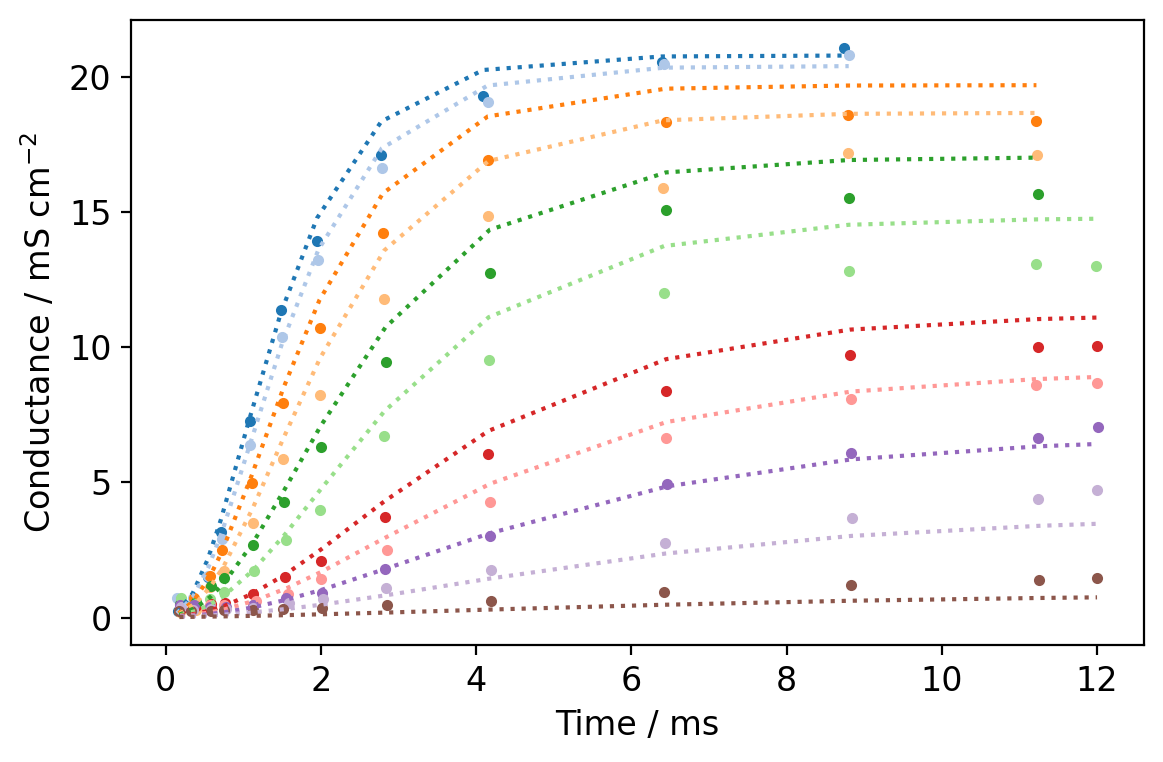

In [45]:
fig, ax = plt.subplots(figsize=(6, 4))
plot_conductances(
    ax,
    data["times"],
    data["depolarizations"],
    data["conductances"],
    show_legend=False,
    linestyle="",
)
plot_conductances(
    ax,
    data["times"],
    data["depolarizations"],
    generated_conductances[index_of_closest],
    show_legend=False,
    marker=None,
)
fig.tight_layout()

While here we selected only the parameter values given the smallest distances between simulations and data, if we instead selected the parameter values with a distance between the simulated outputs and data less than some threshold, we would instead get a _distributional_ estimate of the information we have about the parameters given the data.

## Gradient based parameter fitting with `jax.grad`

While approximate Bayesian computation is conceptually simple, unsuprisingly it becomes very computationally expensive to find even one set of parameter values giving simulated data 'close' to the observations as the parameter and observation dimension increase. Typically a much more efficient approach for finding values of the parameters which give simulated outputs close to data, is to use a gradient-based optimizer to minimize some measure of distance between simulated and observed data with respect to the parameters.

In particular if we assume the observations are subject to Gaussian noise, we can define the objective function to minimise as the negative logarithm of the density of the posterior distribution on the parameters given the observed data under the model. A minima of this objective function then corresponds to a [maximum a posteriori (MAP) estimate](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) of the model parameters.

We can define a function to evaluate the negative log posterior density as follows

In [46]:
def normal_negative_log_density(x, mu=0, sigma=1):
    xp = array_api_compat.array_namespace(x)
    return (((x - mu) / sigma) ** 2).sum() / 2 + x.shape[-1] * xp.log(sigma)


@jax.jit
def negative_log_posterior_density(u, data):
    parameters = generate_parameters(u)
    conductances = solve_for_potassium_conductance(
        data["times"], data["depolarizations"], parameters
    )
    return normal_negative_log_density(u) + normal_negative_log_density(
        conductances, data["conductances"], parameters["sigma"]
    )

We can then use the `jax.value_and_grad` transformation to compute a function which evaluates both the value of the function and its gradient, using reverse mode [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation)

In [47]:
value_and_grad_negative_log_posterior_density = jax.jit(
    jax.value_and_grad(negative_log_posterior_density)
)

We can evaluate the transformed function`value_and_grad_negative_log_posterior_density` function at a test input to check that it correctly gives the same value as `negative_log_posterior_density`

In [48]:
u = rng.standard_normal(dim_parameters)
value, gradient = value_and_grad_negative_log_posterior_density(u, data)
assert np.allclose(value, negative_log_posterior_density(u, data))

and that the gradient returned is consistent with a finite differences approximation

In [49]:
def numerical_grad(f, h=1e-8):
    def grad_f(u, *args):
        xp = array_api_compat.array_namespace(u)
        return xp.array(
            [
                (f(u + h * e_i, *args) - f(u - h * e_i, *args)) / (2 * h)
                for e_i in xp.identity(u.shape[0])
            ]
        )

    return grad_f


assert np.allclose(numerical_grad(negative_log_posterior_density)(u, data), gradient)

Importantly reverse mode differentiation allows us to evaluate both the value and gradient of a function with respect to all inputs at operation cost that is a small constant multiple of the operation cost of evaluating the function itself:

In [50]:
%timeit negative_log_posterior_density(u, data)

42.3 μs ± 3.63 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [51]:
%timeit value_and_grad_negative_log_posterior_density(u, data)

157 μs ± 5.43 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


JAX also provides some example implementations of optimization algorithms that can be used with its automatic differentiation support. The below helper function uses the [adaptive moments (Adam) optimizer](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam) to iteratively minimize an objective function from an initial set of parameter values over a specified number of steps. Internally the function uses the `jax.grad` transformation to construct a function computing the gradient of the objective (with `jax.grad` acting equivalently to `jax.value_and_grad` other than discarding the value of the function and only returning the gradient). To enable the whole helper function to be JIT compiled efficiently, [a structured control primitive `jax.lax.fori_loop`](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.fori_loop.html) from the `jax.lax` interface is used to implement the optimization loop. This avoids unrolling all loops iterations in the traced computation and a resulting very long compilation time. We also mark the `objective` argument as static to allow JAX to trace its computation when JIT compiling.

In [52]:
from jax.example_libraries import optimizers
from functools import partial


@partial(jax.jit, static_argnums=0)
def minimize_with_adam(objective, initial_parameters, n_step, step_size=1e-2):
    initialize, update, get_parameters = optimizers.adam(step_size)
    grad_objective = jax.grad(objective)

    def optimization_step(step, state):
        grads = grad_objective(get_parameters(state))
        return update(step, grads, state)

    initial_state = initialize(initial_parameters)
    # lax.for_i_loop equivalent to:
    # state = initial_state
    # for i in range(n_step):
    #     state = optimization_step(i, state)
    # final_state = state
    final_state = jax.lax.fori_loop(0, n_step, optimization_step, initial_state)
    return get_parameters(final_state)

Using the `minimize_with_adam` helper function, we can compute a MAP estimate of the unconstrained parameter vector and plot the corresponding simulated conductance time series against the observed data.

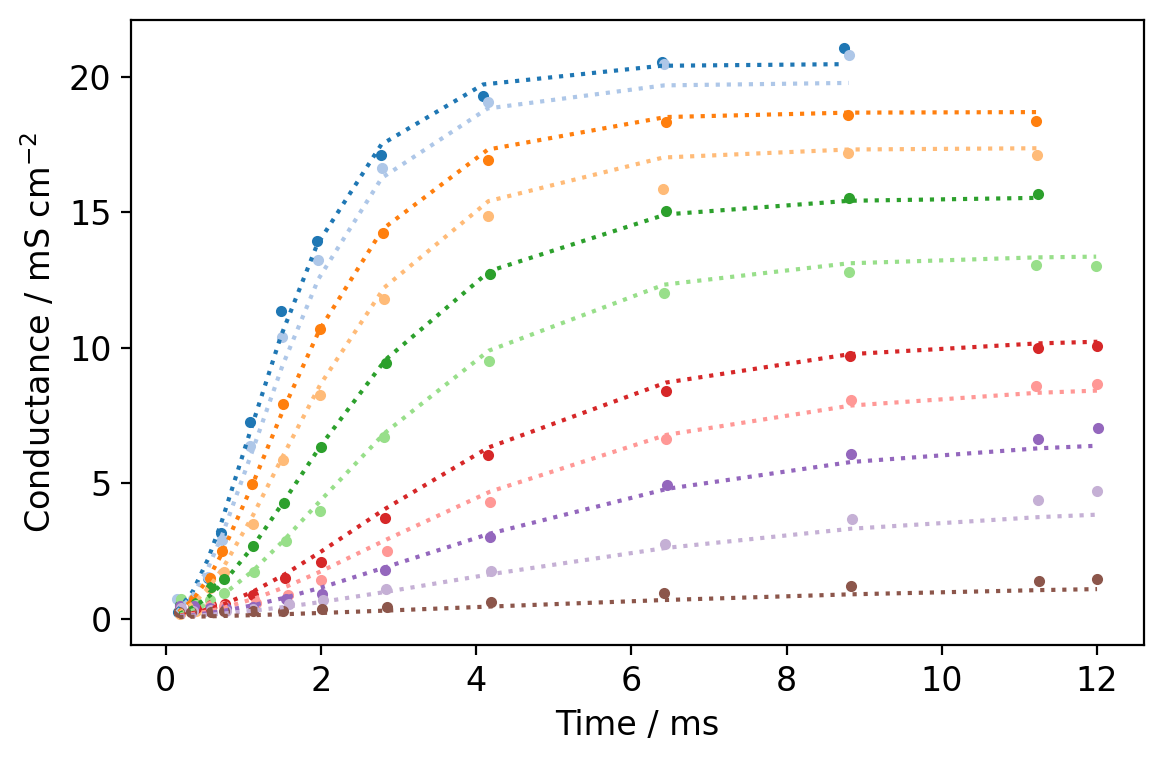

In [53]:
map_u = minimize_with_adam(
    partial(negative_log_posterior_density, data=data),
    rng.standard_normal(dim_parameters),
    10000,
)

fig, ax = plt.subplots(figsize=(6, 4))
map_conductances = generate_conductances(map_u, data)
plot_conductances(
    ax,
    data["times"],
    data["depolarizations"],
    data["conductances"],
    show_legend=False,
    linestyle="",
)
plot_conductances(
    ax,
    data["times"],
    data["depolarizations"],
    map_conductances,
    show_legend=False,
    marker=None,
)
fig.tight_layout()

## Hamiltonian Monte Carlo with Mici

While minimizing the negative log posterior density gives us a point estimate of the parameters, it does not give us any distributional information - that is what is our uncertainty about the parameter values after observing data. An alternative is to use a [Markov chain Monte Carlo (MCMC) method](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) to compute approximate samples from the posterior distribution on the model parameters given data. As a final illustration, we use the package [Mici](https://github.com/matt-graham/mici) to generate approximate samples from the posterior distribution for our Hodgkin-Huxley example, using a gradient-based MCMC method, [Hamiltonian Monte Carlo (HMC)](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo), which uses JAX's automatic differentiation transforms to automatically compute the required derivative functions.

Mici provides a [high-level functional interface](https://matt-graham.github.io/mici/mici.interface.html) as well as a more customisable object oriented interface
Mici supports multiple numerical backends including JAX. We will use the former here, and in particular the [`mici.sample_hmc_chains` function](https://matt-graham.github.io/mici/mici.html#mici.sample_hmc_chains). A key argument we need to pass to this function is a function defining the negative log density of the target distribution; Mici supports multiple numerical backends including JAX, and by passing `backend="jax"` to the function we indicate that the function can be JIT compiled and the required derivatives computed using JAX's automatic differentiation support. Here we additionally specify to sample four chains, each with 1000 adaptive warm-up iterations (in which the step size and metric of the HMC proposals are automatically tuned) and 1000 main iterations. On each main chain iteration we trace (record) the parameter values corresponding to the current chain state. If running on a free-threading enabled build of Python, the chains will be sampled in parallel with one chain per thread, otherwise sequentially.

In [54]:
import sys
import mici
import warnings

warnings.simplefilter("ignore")

n_chain = 4
free_threading_enabled = not sys._is_gil_enabled()

final_states, traces, stats = mici.sample_hmc_chains(
    neg_log_dens=partial(negative_log_posterior_density, data=data),
    backend="jax",
    n_warm_up_iter=1000,
    n_main_iter=1000,
    seed=rng,
    init_states=rng.standard_normal((n_chain, dim_parameters)),
    trace_funcs=[lambda state: generate_parameters(state.pos)],
    adapters=[
        mici.adapters.DualAveragingStepSizeAdapter(),
        mici.adapters.OnlineCovarianceMetricAdapter(),
    ],
    n_worker=n_chain if free_threading_enabled else 1,
    use_thread_pool=free_threading_enabled,
    monitor_stats=["accept_stat", "step_size", "n_step"],
)

Sampling stage: Initial fast adaptive [00:16] > Slow adaptive (1/5) [00:08] > Slow adaptive (2/5) [00:01] > Slow adaptive (3/5) [00:01] > Slow adaptive (4/5) [00:03] > Slow adaptive (5/5) [00:05] > Final fast adaptive [00:00] > Main non-adaptive [00:11]

Chain 1/4: 100%|██████████|1000/1000 [00:11<00:00, 86.33it/s, accept_stat=0.892, step_size=0.280, n_step=12.8]

Chain 2/4: 100%|██████████|1000/1000 [00:11<00:00, 84.49it/s, accept_stat=0.895, step_size=0.280, n_step=13.2]

Chain 3/4: 100%|██████████|1000/1000 [00:11<00:00, 83.70it/s, accept_stat=0.908, step_size=0.280, n_step=13.1]

Chain 4/4: 100%|██████████|1000/1000 [00:11<00:00, 86.06it/s, accept_stat=0.901, step_size=0.280, n_step=12.9]

We can compute summary statistics and convergence diagnostics on the parameter values traced while sampling the chains using the [ArviZ package](https://python.arviz.org/en/stable/)

In [55]:
import arviz

arviz.summary(traces)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k_alpha_1,0.009,0.000,0.009,0.010,0.000,0.000,2270.0,2468.0,1.00
k_alpha_2,0.757,0.372,0.154,1.446,0.010,0.008,1334.0,1181.0,1.00
k_alpha_3,3.543,0.291,2.981,4.082,0.006,0.005,2584.0,2344.0,1.00
k_beta_1,0.107,0.003,0.101,0.113,0.000,0.000,1920.0,2110.0,1.00
k_beta_2,376.052,175.845,160.660,683.282,7.417,14.586,779.0,634.0,1.01
g_bar_k,27.512,0.977,25.534,29.226,0.034,0.022,820.0,939.0,1.01
sigma,0.349,0.022,0.308,0.389,0.000,0.000,4016.0,2807.0,1.00


We can also visualise the estimated posterior distribution on the parameters as a pair plot using [corner.py](https://corner.readthedocs.io/en/latest/), overlaying the MAP parameters as an orange marker

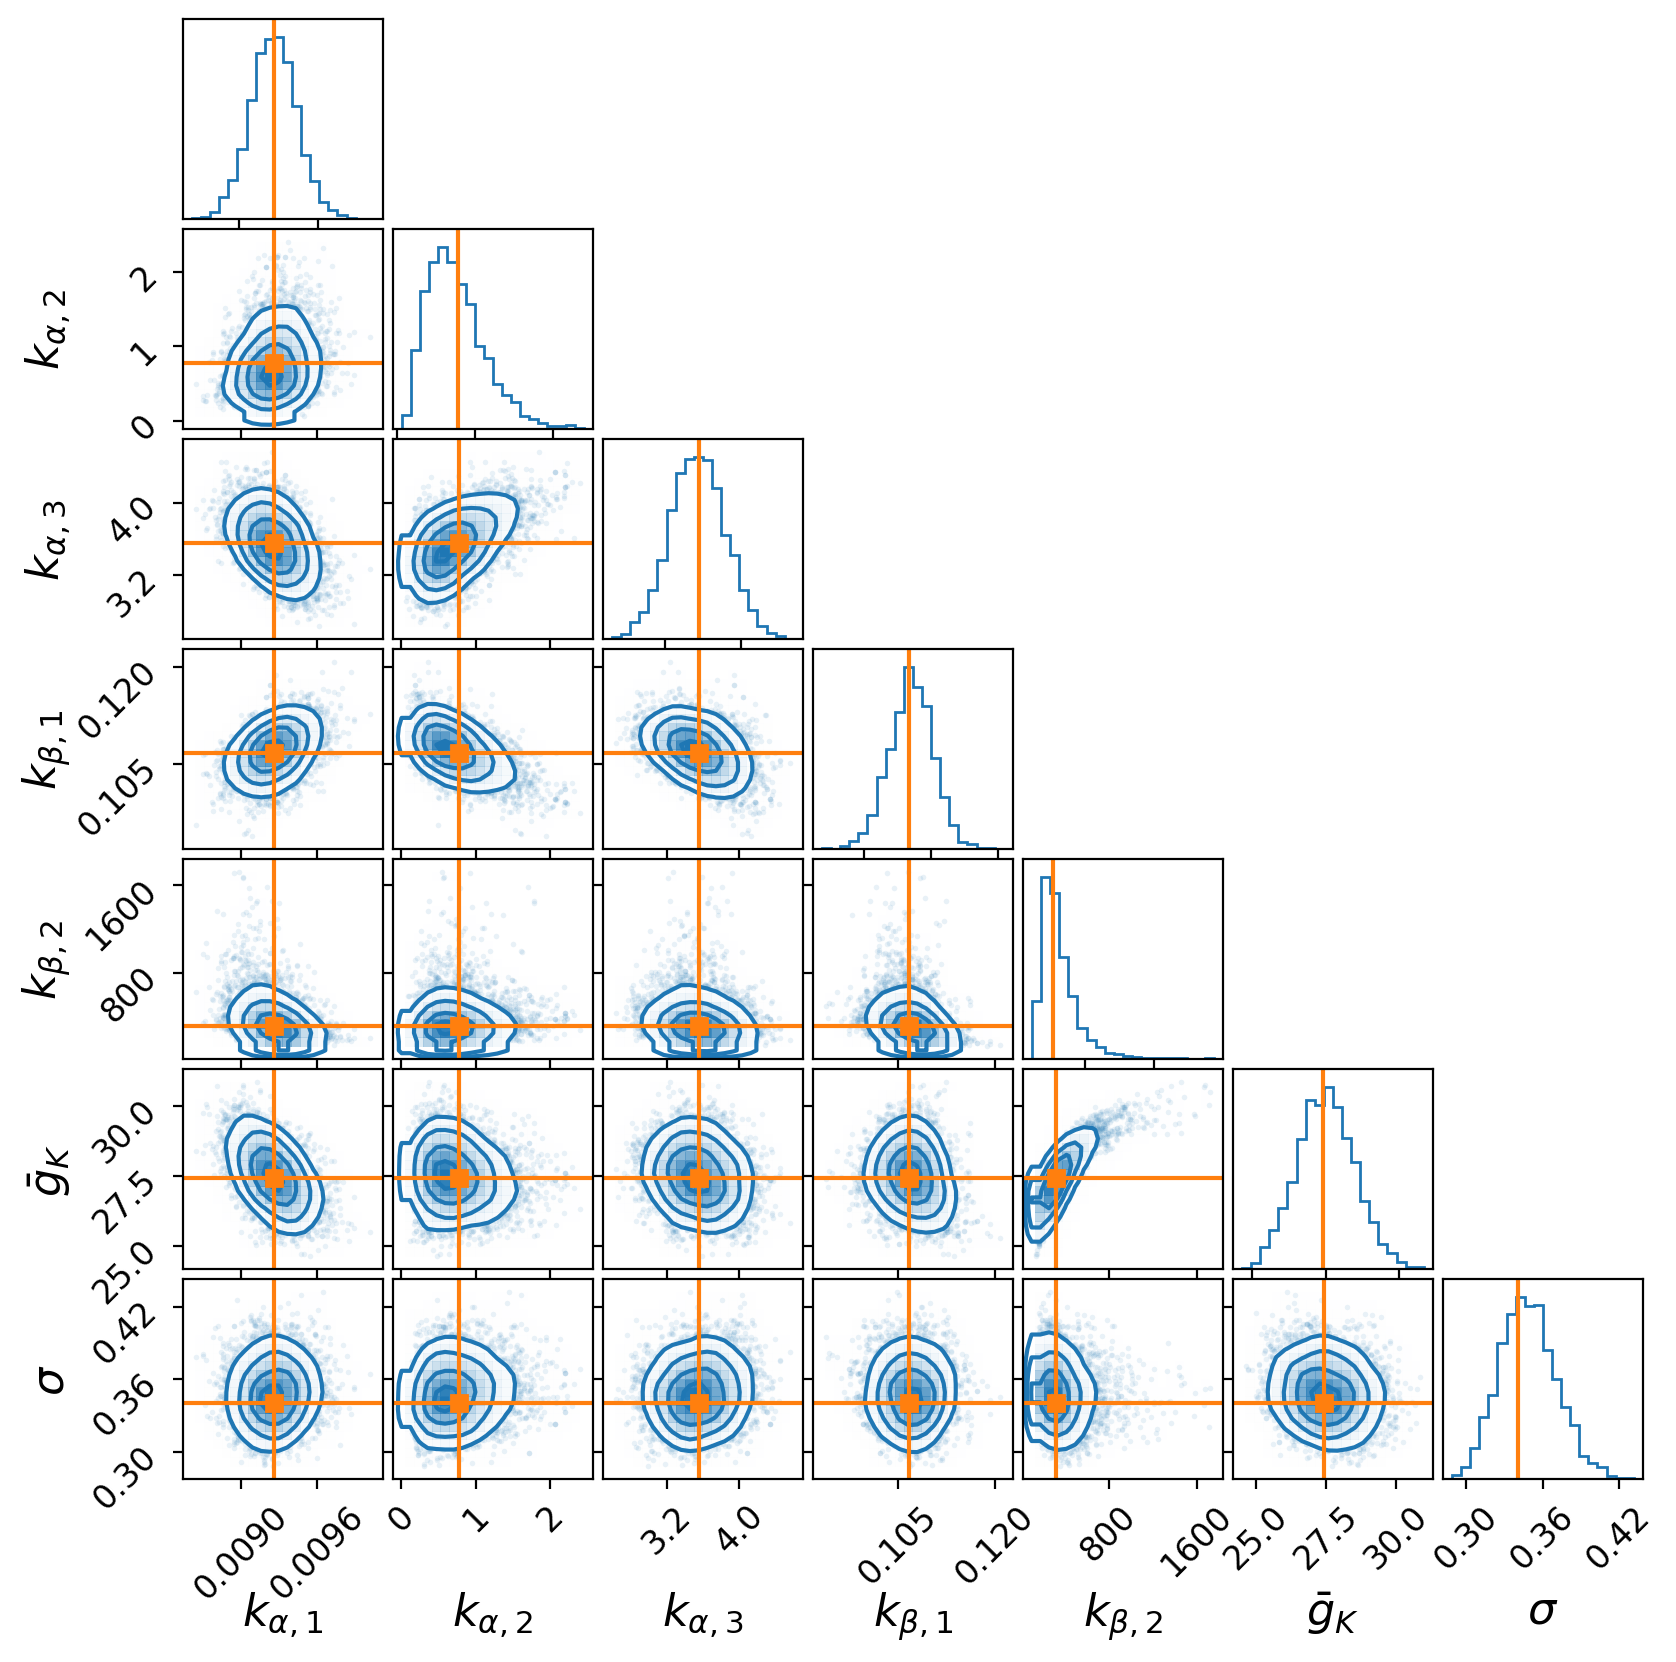

In [56]:
import corner

fig, axes = plt.subplots(dim_parameters, dim_parameters, figsize=(8, 8), dpi=100)
labeller = arviz.labels.MapLabeller(
    {
        "k_alpha_1": r"$k_{\alpha,1}$",
        "k_alpha_2": r"$k_{\alpha,2}$",
        "k_alpha_3": r"$k_{\alpha,3}$",
        "k_beta_1": r"$k_{\beta,1}$",
        "k_beta_2": r"$k_{\beta,2}$",
        "g_bar_k": r"$\bar{g}_K$",
        "sigma": r"$\sigma$",
    }
)
map_parameters = generate_parameters(map_u)
_ = corner.corner(
    traces,
    smooth=1,
    fig=fig,
    max_n_ticks=3,
    labelpad=0.25,
    label_kwargs={"fontsize": 16},
    color="C0",
    labeller=labeller,
    truths=map_parameters,
    truth_color="C1",
)